In [ ]:
#default_exp vision.core
#default_cls_lvl 3

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.data.transform import *
from local.data.pipeline import *
from local.data.core import *
from local.data.external import *

from PIL import Image

In [ ]:
#export
_all_ = ['Image']

# Core vision
> Basic image opening/processing functionality

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
# TODO: docs

In [ ]:
#export
def load_image(fn, *args, **kwargs):
    im = Image.open(fn, *args, **kwargs)
    im.load()
    return im._new(im.im)

In [ ]:
#export
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _show_args = {'cmap':'viridis'}
    @classmethod
    def open(cls, fn, *args, **kwargs)->None:
        "Open an `Image` from path `fn`"
        return cls(load_image(fn, *args, **kwargs))
    def show(self, ctx=None, **kwargs): return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

In [ ]:
#export
class PILImage(PILBase): pass

In [ ]:
#export
class PILMask(PILBase): _show_args = {'alpha':0.5, 'cmap':'tab20'}

In [ ]:
im = PILImage.open(TEST_IMAGE)
test_eq(type(im), PILImage)

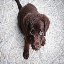

In [ ]:
im.resize((64,64))

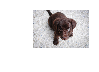

In [ ]:
ax = im.show(figsize=(1,1))

In [ ]:
test_fig_exists(ax)

In [ ]:
im = PILMask.open(TEST_IMAGE)
test_eq(type(im), PILMask)

### Images

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
fns = get_image_files(mnist)
mnist_fn = fns[0]; mnist_fn

PosixPath('/home/jhoward/git/fastai_docs/dev/data/mnist_tiny/train/3/8055.png')

In [ ]:
timg = Transform(PILImage.open)
mnist_img = timg(mnist_fn)
test_eq(mnist_img.size, (28,28))
assert isinstance(mnist_img, PILImage)
mnist_img

### Segmentation masks

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
fns = get_image_files(camvid)
cam_fn = fns[0]
mask_fn = camvid/'labels'/f'{cam_fn.stem}_P{cam_fn.suffix}'

In [ ]:
cam_img = timg(cam_fn)
test_eq(cam_img.size, (128,96))
tmask = Transform(PILMask.open)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (128,96))

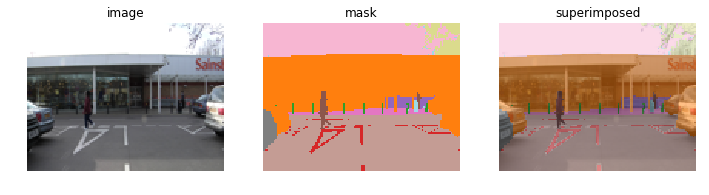

In [ ]:
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

### Points

In [ ]:
# export
class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float())

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        ctx.scatter(self[:, 0], self[:, 1], **{**self._show_args, **kwargs})
        return ctx

Points are expected to come as an array/tensor of shape `(n,2)` or as a list of lists with two elements. Unless you change the defaults in `PointScaler` (see later on), coordinates should go from 0 to width/height, with the first one being the column index (so from 0 to width) and the second one being the row index (so from 0 to height).

> Note: This is differnt from the usual indeixing convention for arrays in numpy or in PyTorch, but it's the way points are expected by matplotlib or the internal functions in PyTorch like `F.grid_sample`.

In [ ]:
pnt_img = TensorImage(mnist_img.resize((28,35)))
pnts = np.array([[0,0], [0,35], [28,0], [28,35], [9, 17]])
tfm = Transform(TensorPoint.create)
tpnts = tfm(pnts)
test_eq(tpnts.shape, [5,2])
test_eq(tpnts.dtype, torch.float32)

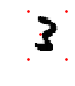

In [ ]:
ctx = pnt_img.show(figsize=(1,1), cmap='Greys')
tpnts.show(ctx=ctx);

### Bounding boxes

In [ ]:
# export
#TODO: copy func or rewrite
# from fastai.vision.data import get_annotations

In [ ]:
# export
from matplotlib import patches, patheffects

def _draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def _draw_rect(ax, b, color='white', text=None, text_size=14, hw=True, rev=False):
    lx,ly,w,h = b
    if rev: lx,ly,w,h = ly,lx,h,w
    if not hw: w,h = w-lx,h-ly
    patch = ax.add_patch(patches.Rectangle((lx,ly), w, h, fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(lx,ly, text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
# export
class TensorBBox():
    "Basic type for a list of bounding boxes in an image"
    def __init__(self, x): self.bbox,self.lbl = tensor(x[0]).view(-1, 4).float(),x[1]
    def __repr__(self): return f'{self.bbox}; {self.lbl}'

    def show(self, ctx=None, **kwargs):
        for b,l in zip(self.bbox, self.lbl): 
            if l != '#bg': _draw_rect(ctx, b, hw=False, text=l)
        return ctx

Bounding boxes are expected to come as tuple with an array/tensor of shape `(n,4)` or as a list of lists with four elements adn a list of corresponding labels. Unless you change the defaults in `BBoxScaler` (see later on), coordinates for each bounding box should go from 0 to height/width, with the following convetion: top, left, bottom, right.

> Note: We use the same convention as for points with y axis being before x.

In [ ]:
# export
def get_annotations(fname, prefix=None):
    "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."
    annot_dict = json.load(open(fname))
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list)
    classes = {o['id']:o['name'] for o in annot_dict['categories']}
    for o in annot_dict['annotations']:
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]])
        id2cats[o['image_id']].append(classes[o['category_id']])
    id2images = {o['id']:ifnone(prefix, '') + o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]

In [ ]:
#hide
#TODO explain and/or simplify this
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
annots = json.load(open(coco/'train.json'))
test_eq(images, [k['file_name'] for k in annots['images']])
for _ in range(5):
    idx = random.randint(0, len(images)-1)
    fn = images[idx]
    i = 0
    while annots['images'][i]['file_name'] != fn: i+=1
    img_id = annots['images'][i]['id']
    bbs = [ann for ann in annots['annotations'] if ann['image_id'] == img_id]
    i2o = {k['id']:k['name'] for k in annots['categories']}
    lbls = [i2o[bb['category_id']] for bb in bbs]
    bboxes = [bb['bbox'] for bb in bbs]
    bboxes = [[bb[0],bb[1], bb[0]+bb[2], bb[1]+bb[3]] for bb in bboxes]
    test_eq(lbl_bbox[idx], [bboxes, lbls])

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
idx=2
coco_fn,bbox = coco/'train'/images[idx],lbl_bbox[idx]
coco_img = timg(coco_fn)

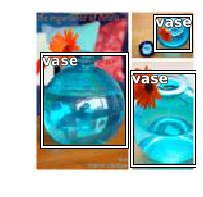

In [ ]:
tbbox = TensorBBox(bbox)
ctx = coco_img.show(figsize=(3,3), cmap='Greys')
tbbox.show(ctx=ctx);

## Basic Transforms

Unless specifically metioned, all the following transforms can be used as single-item transforms (in one of the list in the `tfms` you pass to a `TfmdDS` or a `Datasource`) or tuple transform (in the `tuple_tfms` you pass to a `TfmdDS` or a `Datasource`). The safest way that will work accross applications is to always use them as `tuple_tfms`. For instance, if you have points or bounding boxes as targets and use `ImageResizer` as a single-item transform, when you get to `PointScaler` or `BBoxScaler` (which are tuple transforms) you won't have the correct size of the image to properly scale your points.

In [ ]:
#export
class ImageConverter(Transform):
    "Convert an image or a mask to `mode`/`mode_mask`"
    def __init__(self, mode='RGB', mask_mode='L'): self.modes = (mode,mask_mode)
    def encodes(self, o:PILImage): return o.convert(self.modes[0])
    def encodes(self, o:PILMask):  return o.convert(self.modes[1])

In [ ]:
f = ImageConverter('RGB')
f.accept_types(PILImage)
test_eq(f(mnist_img).mode, 'RGB')
f.accept_types(Mask)
test_eq(f(mask).mode, 'L')

In [ ]:
#export
class ImageResizer(Transform):
    order=10
    "Resize image to `size` using `resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:Mask):     return o.resize(size=self.size, resample=Image.NEAREST)

`size` can either be one integer (in which case images are resized to a square) or a tuple `height,width`.

> Note: This is the usual convention for arrays or in PyTorch, but it's not the usual convention for PIL Image, which use the other way round.

In [ ]:
f = ImageResizer(14)
f.accept_types(PILImage)
test_eq(f(mnist_img).size, (14,14))
f.accept_types(Mask)
test_eq(f(mask).size, (14,14))

f = ImageResizer((32,28))
f.accept_types(PILImage)
test_eq(f(mnist_img).size, (28,32))#PIL has width first
test_eq(array(f(mnist_img)).shape, (32,28))#But numpy as height first and that is our convention

In [ ]:
# export
def image2byte(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    w,h = img.size
    return res.view(h,w,-1).permute(2,0,1)

In [ ]:
#export
class ImageToByteTensor(Transform):
    "Transform image to byte tensor in `c*h*w` dim order."
    order=15
    def encodes(self, o:PILImage)->TensorImage: return image2byte(o)
    def encodes(self, o:Mask)    ->TensorMask:  return image2byte(o)[0]

Any data augmentation transform that runs on PIL Images must be run before this transform, so with an order attribute from 1 to 9.

In [ ]:
tfm = ImageToByteTensor()
tfm.accept_types(PILImage)
test_eq(tfm(mnist_img).shape, (1,28,28))
test_eq(tfm.return_type(), TensorImage)
tfm.accept_types(Mask)
test_eq(tfm(mask).shape, (96,128))
test_eq(tfm.return_type(), TensorMask)

Let's confirm we can pipeline this with `Imagify`.

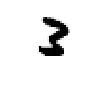

In [ ]:
pipe_img = Pipeline([Imagify(), ImageToByteTensor()])
img = pipe_img(mnist_fn)
test_eq(img.shape, (1,28,28))
PILImage.kwargs['cmap'] = 'Greys'
pipe_img.show(img, figsize=(1,1));

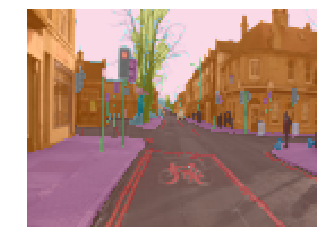

In [ ]:
def _cam_lbl(x): return mask_fn
cam_tds = TfmdDS([cam_fn], [Imagify(), [_cam_lbl, Maskify()]], tuple_tfms=ImageToByteTensor())
cam_tds.show_at(0);

In [ ]:
# export
class PointScaler(Transform):
    "Scale a tensor representing points"
    def __init__(self, do_scale=True, y_first=False): self.do_scale,self.y_first = do_scale,y_first
    
    def encodes(self, x, y:TensorPoint):
        if self.y_first: y = y.flip(1)
        sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
        if self.do_scale: y = y * 2/tensor(sz).float() - 1
        return (x,y)
    
    def decodes(self, x, y:TensorPoint):
        sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
        y = (y+1) * tensor(sz).float()/2
        return (x,y)

To work with data augmentation, and in particular the `grid_sample` method, points need to be represented with coordinates going from -1 to 1 (-1 being top or left, 1 bottom or right), which will be done unless you pass `do_scale=False`. We also need to make sure they are following our convention of points being x,y coordinates, so pass along `y_first=True` if you have your data in an y,x format to add a flip.

> Warning: This transform needs to run on the tuple level, before any transform that changes the image size.

In [ ]:
def _pnt_lbl(x): return pnts
def _pnt_open(fn): return Image.open(fn).resize((28,35))
pnt_tds = TfmdDS([mnist_fn], [Imagify(_pnt_open), [_pnt_lbl,Pointify()]], 
                 tuple_tfms=[PointScaler(), ImageToByteTensor()])

In [ ]:
x,y = pnt_tds[0]
#Scaling and flipping properly done
test_close(y, tensor([[-1., -1.], [-1.,  1.], [1.,  -1.], [1., 1.], [9/14-1, 17/17.5-1]]))
a,b = pnt_tds.decode((x,y))
test_eq(b, tensor(pnts).float())

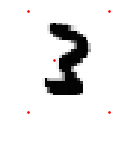

In [ ]:
pnt_tds.show_at(0, figsize=(2,2));

In [ ]:
# export
class BBoxScaler(PointScaler):
    "Scale a tensor representing bounding boxes"
    def encodes(self, x, y:TensorBBox): 
        scaled_bb = self._get_func(super().encodes, self.t)(x,y[0].view(-1,2))[1]
        return (x,(scaled_bb.view(-1,4),y[1]))
    
    def decodes(self, x, y:TensorBBox):
        scaled_bb = self._get_func(super().decodes, self.t)(x,y[0].view(-1,2))[1]
        return (x, (scaled_bb.view(-1,4), y[1]))

In [ ]:
# export
class BBoxCategorize(Transform):
    "Reversible transform of category string to `vocab` id"
    order,state_args=1,'vocab'
    def __init__(self, vocab=None, subset_idx=None):
        self.vocab,self.subset_idx = vocab,subset_idx
        self.o2i = None if vocab is None else {v:k for k,v in enumerate(vocab)}
        
    def setup(self, dsrc):
        if not dsrc: return
        dsrc = dsrc.train if self.subset_idx is None else dsrc.subset(self.subset_idx)
        vals = set()
        for b,c in dsrc: vals = vals.union(set(c))
        self.vocab,self.otoi = uniqueify(list(vals), sort=True, bidir=True, start='#bg')

    def encodes(self, o): return (o[0],tensor([self.otoi[o_] for o_ in o[1] if o_ in self.otoi]))
    def decodes(self, i): return (i[0],[self.vocab[i_] for i_ in i[1]])

In [ ]:
def _coco_lbl(x): return bbox
tcat = BBoxCategorize(subset_idx=[0])
coco_tds = TfmdDS([coco_fn], [Imagify(), [_coco_lbl, BBoxify(), tcat]], tuple_tfms=[BBoxScaler(), ImageToByteTensor()])

In [ ]:
x,y = coco_tds[0]
#Scaling and flipping properly done
test_close(y[0], -1+tensor(bbox[0])/64)
test_eq(y[1], tensor([1,1,1]))
a,b = coco_tds.decode((x,y))
test_close(b[0], tensor(bbox[0]).float())
test_eq(b[1], bbox[1])

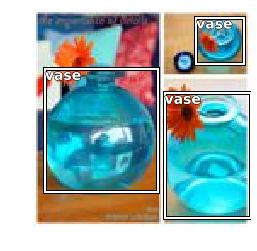

In [ ]:
coco_tds.show_at(0);

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial-meta.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_vision_augment.ipynb.
Converted 09_data_block.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 13_callback_schedule.ipynb.
Converted 14_callback_hook.ipynb.
Converted 15_callback_progress.ipynb.
Converted 16_callback_tracker.ipynb.
Converted 17_callback_fp16.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
Converted 95_synth_learner.ipynb.
